# Overview
This project explores Aspect Based Sentiment Analysis from MyAnimeList for anime reviews.

This project consists of three main parts. First, we scrap the reviews. Second, me model the sentiment analysis. Third, we present the sorted anime rankings using the outputs of the sentiment analysis.

# Webscraper

In [125]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time

from anime_absa import get_overall_review_sentiment

reviews = []
for page in range(1,5): # TODO Make this page limit dynamic
    #url = f"https://myanimelist.net/anime/1735/Naruto__Shippuuden/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    #url = f"https://myanimelist.net/anime/22319/Tokyo_Ghoul/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    #url = f"https://myanimelist.net/anime/34798/Yuru_Camp%E2%96%B3/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    #url = f"https://myanimelist.net/anime/37999/Kaguya-sama_wa_Kokurasetai__Tensai-tachi_no_Renai_Zunousen/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    #url = f"https://myanimelist.net/anime/39535/Mushoku_Tensei__Isekai_Ittara_Honki_Dasu/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    # DMC has 5 pages
    url = "https://myanimelist.net/anime/1726/Devil_May_Cry/reviews?sort=suggested&filter_check=&filter_hide=&preliminary=on&spoiler=on&p={page}"
    page = urlopen(url)
    html_bytes = page.read()
    html = html_bytes.decode("utf-8")
    soup = BeautifulSoup(html)
    reviews.extend(soup.find_all("div", attrs={"class": "review-element js-review-element"}))
    for review in reviews:
        print(review.prettify())
    time.sleep(0.5)

<div class="review-element js-review-element" data-reactions='{"icon":["1","3","4"],"num":454,"count":["441","1","6","3","2","1","0"]}'>
 <div class="thumbbody mt8">
  <div class="thumb">
   <a class="ga-click" data-ga-click-type="review-anime-reviewer-pic" href="https://myanimelist.net/profile/moozooh">
    <img class="lazyloaded" data-src="https://cdn.myanimelist.net/s/common/userimages/ebce0ee5-3ea6-4c2e-b11c-0e02ba4b6d88_42x62_i?s=3a2063f99215200f03c6a81981c91a2f" src="https://cdn.myanimelist.net/s/common/userimages/ebce0ee5-3ea6-4c2e-b11c-0e02ba4b6d88_42x62_i?s=3a2063f99215200f03c6a81981c91a2f" width="48"/>
   </a>
  </div>
  <div class="body">
   <div class="update_at" title="8:18 PM">
    Sep 13, 2007
   </div>
   <div class="username">
    <a class="ga-click" data-ga-click-type="review-anime-reviewer" href="https://myanimelist.net/profile/moozooh">
     moozooh
    </a>
   </div>
   <div class="tags">
    <div class="tag mixed-feelings btn-label js-btn-label" data-href="https:/

In [126]:
clean_reviews = []
for review in reviews:
    recommend = review.find("div", class_= "tag").get_text()
    review_text = review.find("div", attrs={"class": "text"})
    
    if review_text.span is not None:
        
        review_text.span.extract()
        extended_review = review_text.span.extract().get_text()
        clean_reviews.append((recommend,review_text.get_text() + extended_review))
for clean_review in clean_reviews:
    print(clean_review)
    print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


('Mixed Feelings', '\n                Devil May Cry is a very strange series. It does its thing nicely for a bit but then goes and ruins it with some silly nonsense. I have no idea why or how that happened. I mean, the games are pretty consistently decent—so why isn\'t this show the same?\n\r\nLet\'s begin with this totally alien concept called the story. Of which you won\'t be getting any for about 9 episodes in a row (yes, out of 12 total). No joke—this is essentially a slice-of-life series about Dante showing off. And before you ask the obvious question—yes, it has less of a story than the action games\n                  \n\nthe setting is taken from. Furthermore—just to tease you—at several points you get an impression that some general plot is about to emerge (it eventually does, but already after you have lost all hope for it), but the very next moment you have your expectations casually ruined once again. You could probably even watch episodes 2–9 in any order without disturbing

In [127]:
print(len(clean_reviews))

72


# ABSA sentiment


In [128]:
import torch
# Check if gpu is available.
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.backends.cuda.is_built())

False
0
False


In [129]:
import json
import textwrap

data = [review[1] for review in clean_reviews]
absa_review_sentiments = []
noaspectterm_list = []
aspect_reviews = []
for text in data:
    chunk_sentiments = []
    overall_sentiment_mapping = []
    print("==============STARTING NEW REVIEW==============")
    for text_chunk in textwrap.wrap(text, 512):
        chunk_sentiment_results = get_overall_review_sentiment(text_chunk)
        if chunk_sentiment_results is None:
            continue
        chunk_sentiment = chunk_sentiment_results[0]
        chunk_sentiments.append(chunk_sentiment)
        chunk_aspect_sentiment_mapping = chunk_sentiment_results[1]
        overall_sentiment_mapping.extend(chunk_aspect_sentiment_mapping)

    if len(chunk_sentiments) == 0:
        noaspectterm_list.append(text)
    else:
        aspect_reviews.append(text)
        avg_sentiment = sum(chunk_sentiments) / len(chunk_sentiments)
        absa_review_sentiments.append([avg_sentiment, overall_sentiment_mapping])

json_noaspect_reviews = json.dumps(noaspectterm_list, indent=4)
with open('noaspectterm_reviews.json','w') as f:
    f.write(json_noaspect_reviews)

json_aspect_reviews = json.dumps(aspect_reviews, indent=4)
with open('aspectterm_reviews.json','w') as f:
    f.write(json_aspect_reviews)

==============STARTING NEW REVIEW==============
Extraction Model output:  games, story
Sentiment Model output:  positive
Sentiment Model output:  none
Extraction Model output:  setting, story
Sentiment Model output:  neutral
Sentiment Model output:  none
noaspectterm found
Extraction Model output:  food, food, swag, style, weapons, chump gourmet garbage
Sentiment Model output:  neutral
Sentiment Model output:  neutral
Sentiment Model output:  positive
Sentiment Model output:  positive
Sentiment Model output:  negative
Sentiment Model output:  none
noaspectterm found
Extraction Model output:  characters, cast
Sentiment Model output:  neutral
Sentiment Model output:  neutral
Extraction Model output:  foils
Sentiment Model output:  negative
Extraction Model output:  screen time, Trish, Lady, Dante
Sentiment Model output:  none
Sentiment Model output:  negative
Sentiment Model output:  neutral
Sentiment Model output:  negative
noaspectterm found
Extraction Model output:  sound, visuals, mu

In [130]:
accuracy_list = []
reviews_with_ratings = []
true_pos, true_neg, false_pos, false_neg, = 0,0,0,0
for i in range(len(absa_review_sentiments)):
    if absa_review_sentiments[i][0] is not None:
        reviews_with_ratings.append({
            "prediction" : absa_review_sentiments[i][0],
            "aspect_sentiment_mapping": absa_review_sentiments[i][1],
            "actual" : clean_reviews[i][0],
            "text" : data[i]
        })
        if (absa_review_sentiments[i][0] > 0.5 and clean_reviews[i][0] == "Recommended"):
            true_pos += 1 # absa review sentiment was on the positive half, and actually recommended. true pos.
        elif (absa_review_sentiments[i][0] <= 0.5 and clean_reviews[i][0] == "Not Recommended"):
            true_neg +=1 # thought gave a negative review, and actually gave a negative review. true neg.
        elif (absa_review_sentiments[i][0] <= 0.5 and clean_reviews[i][0] == "Recommended"):
            false_neg +=1 # absa sentiment was on the false side, but was actually recommended. false neg.
        elif (absa_review_sentiments[i][0] > 0.5 and clean_reviews[i][0] == "Not Recommended"):
            false_pos +=1 # absa sentiment was on the positive, but was not recommended. false pos.

json_reviews = json.dumps(reviews_with_ratings, indent=4)
with open('json_reviews.json','w') as f:
    f.write(json_reviews)

print(f"The correct guesses are: {true_pos + true_neg} and the wrong guesses are: {false_pos + false_neg}.")

print(f"true_pos: {true_pos}, true_neg: {true_neg}, false_pos: {false_pos}, false_neg: {false_neg}")

The correct guesses are: 22 and the wrong guesses are: 22.
true_pos: 16, true_neg: 6, false_pos: 12, false_neg: 10


In [131]:
print("begin")
def sentiment_word_to_float(word):
    if word == "positive":
        return 1
    elif word == "conflict" or word == "neutral":
        return 0.5
    elif word == "negative":
        return 0
    else:
        return None
print("After function")

begin
After function


# Total Aspect List
We're gonna get all the different aspects that were found, the sentiment associated with those aspects, and most importantly we're going to aggregate shared aspects across the review.

In [132]:
aggregate_aspects = {}
for absa_result in absa_review_sentiments:
    sentiment_mapping = absa_result[1]
    for sentiment in sentiment_mapping:
        if sentiment_word_to_float(sentiment["sentiment"]) is not None:
            if sentiment["aspect"] not in aggregate_aspects:
                    aggregate_aspects[sentiment["aspect"]] = {"total_sentiment": sentiment_word_to_float(sentiment["sentiment"]),
                                                              "occurrences": 1,
                                                              "average_sentiment" : 0}
            else:
                 aggregate_aspects[sentiment["aspect"]] = {
                     "total_sentiment": aggregate_aspects[sentiment["aspect"]]["total_sentiment"] + sentiment_word_to_float(sentiment["sentiment"]),
                     "occurrences": aggregate_aspects[sentiment["aspect"]]["occurrences"] + 1,
                     "average_sentiment" : 0
                 }
for aggregate_aspect in aggregate_aspects.keys():
    aggregate_aspects[aggregate_aspect]["average_sentiment"] = aggregate_aspects[aggregate_aspect]["total_sentiment"] / aggregate_aspects[aggregate_aspect]["occurrences"]
    
print(json.dumps(aggregate_aspects, indent=4))

{
    "games": {
        "total_sentiment": 24.0,
        "occurrences": 28,
        "average_sentiment": 0.8571428571428571
    },
    "setting": {
        "total_sentiment": 2.0,
        "occurrences": 4,
        "average_sentiment": 0.5
    },
    "food": {
        "total_sentiment": 4.0,
        "occurrences": 8,
        "average_sentiment": 0.5
    },
    "swag": {
        "total_sentiment": 4,
        "occurrences": 4,
        "average_sentiment": 1.0
    },
    "style": {
        "total_sentiment": 4,
        "occurrences": 8,
        "average_sentiment": 0.5
    },
    "weapons": {
        "total_sentiment": 0,
        "occurrences": 4,
        "average_sentiment": 0.0
    },
    "characters": {
        "total_sentiment": 32.0,
        "occurrences": 36,
        "average_sentiment": 0.8888888888888888
    },
    "cast": {
        "total_sentiment": 2.0,
        "occurrences": 4,
        "average_sentiment": 0.5
    },
    "foils": {
        "total_sentiment": 0,
        "occurr

In [133]:
from operator import getitem

# aggregate_aspects.items() gives the dictionary as a list of tuples with the key as element 0 of the tuple and the value as element 1
# The lambda is a function to get the value of "occurrences" from the nested dictionary
sorted_aggregate = {key: val for key, val in sorted(aggregate_aspects.items(), key = lambda element_to_sort: getitem(element_to_sort[1], 'occurrences'), reverse=True)}

most_common_aspects_json = json.dumps(sorted_aggregate, indent=4)
with open('most_common_aspects.json','w') as f:
    f.write(most_common_aspects_json)
    
OCCURRENCE_THRESHOLD = 1
# Same as above loop to only add aspects that show up more than just a few times
multi_occurrence_aggregate_aspects = {key: val for key, val in sorted(aggregate_aspects.items(), key = lambda element_to_sort: getitem(element_to_sort[1], 'occurrences'), reverse=True) if val["occurrences"] > OCCURRENCE_THRESHOLD}

# Same as original loop to get most occurrences but now sort by highest sentiment
top_sentiments = {key: val for key, val in sorted(multi_occurrence_aggregate_aspects.items(), key = lambda element_to_sort: getitem(element_to_sort[1], 'average_sentiment'), reverse=True)}

favorite_aspects_json = json.dumps(top_sentiments, indent=4)
with open('favorite_aspects.json','w') as f:
    f.write(favorite_aspects_json)
    

# Cluster review aspects to known categories using Word2Vec

In [134]:
import json

from gensim.models import KeyedVectors
pretrained_model_path = './pretrained_models/GoogleNews-vectors-negative300.bin.gz' 
word_vectors = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=True)

In [135]:
favorite_aspects = None
with open("./favorite_aspects.json") as file:
    favorite_aspects = json.load(file)
    
    file.close()
    
canonical_aspect_terms = {
    "Narrative": ["voice actors", "story line", "world building", "storyline", "development", "backstories", "lore", "world", "setting", "locations", "openings", "backstory", "plot", "story", "narrative", "story arcs", "arcs", "atmosphere", "ending", "writing", "opening", "content", "flashbacks", "length"],
    "Visual": ["artwork", "fight scenes", "style", "scenes", "character designs", "design", "art", "art style", "animation quality", "scene", "animation"],
    "Audio": ["music", "voice acting", "soundtracks", "soundtrack", "sound effects", "music", "background music", "sound"],
    "Miscellaneous": ["miscellaneous"],
    "Character": [
    "Characters", "character", "cast", "cast of characters", "main cast", "supporting cast", "cast member", "set of characters",
    "character cast", "main characters",
    "Protagonist", "main character", "MC", "lead", "female lead",
    "Antagonist depth", "Side characters", "supporting cast impact",
    "Character development", "development", "character growth",
    "character depth", "characterizations", "characterization", "character writing",
    "Character relationships", "relationships", "chemistry between characters", "relationship", "dynamics", "team dynamics", "character interactions",
    "Character design", "character expressions", "tsundere", "tsunderes",
    "Backstories", "character story gaps", "motives", "personalities", "attitude",
    "Character exposition", "character dialogue", "Female characters"]
}

canonical_aspect_scores = {canonical_aspect: {
        "total_sentiment": 0,
        "occurrences": 0,
        "average_sentiment": 0,
        "terms": []
    } for canonical_aspect in canonical_aspect_terms}

for review_aspect, review_aspect_data in favorite_aspects.items():
    lowercase_review_aspect = review_aspect.lower()
    canonical_aspect_similarities = {}
    most_similar_canonical_aspect = None
    for canonical_aspect, sub_terms in canonical_aspect_terms.items():
        if lowercase_review_aspect in sub_terms:
            # Force this review_aspect to be associated with this canonical_aspect
            most_similar_canonical_aspect = canonical_aspect
            break
        else:
            # Use word2vec to find most similar sub-term 
            sum_similarity = 0
            for sub_term in sub_terms:
                try:
                    similarity = word_vectors.similarity(lowercase_review_aspect, sub_term)
                    sum_similarity += similarity
                    # print(f"Similarity between {review_aspect} and {sub_term} is {similarity}")
                except:
                    print(f"Couldn't get similarity between {lowercase_review_aspect} and {sub_term}")

            average_similarity = sum_similarity / len(sub_terms)
            canonical_aspect_similarities[canonical_aspect] = average_similarity
            
    decision_method = "Hard Match"
    # If we never got a "hard match" matching the review aspect exactly with a canonical aspect sub term:
    if most_similar_canonical_aspect is None:
        # Then we use the most similar aspect according to word2vec
        decision_method = "Word2Vec"
        most_similar_canonical_aspect = max(canonical_aspect_similarities, key=canonical_aspect_similarities.get)
        
        # If it couldn't decide a most similar category (this happens when the review aspect is not in the word2vec model OR in the hard list):
        if canonical_aspect_similarities[most_similar_canonical_aspect] == 0:
            most_similar_canonical_aspect = "Miscellaneous"
        
    print(f"The most similar canonical aspect to \"{review_aspect}\" is \"{most_similar_canonical_aspect}\" ({decision_method})")
    
    favorite_aspects[review_aspect]["most_similar_canonical_aspect"] = most_similar_canonical_aspect
    
    canonical_aspect_scores[most_similar_canonical_aspect]["total_sentiment"] += review_aspect_data["total_sentiment"]
    canonical_aspect_scores[most_similar_canonical_aspect]["occurrences"] += review_aspect_data["occurrences"]
    canonical_aspect_scores[most_similar_canonical_aspect]["terms"].append(review_aspect)
        
for aspect, data in canonical_aspect_scores.items():
    canonical_aspect_scores[aspect]["average_sentiment"] = canonical_aspect_scores[aspect]["total_sentiment"]/canonical_aspect_scores[aspect]["occurrences"]
    
print(json.dumps(canonical_aspect_scores, indent=4, sort_keys=True)) 

favorite_aspects_json = json.dumps(favorite_aspects, indent=4)
with open('favorite_aspects.json','w') as f:
    f.write(favorite_aspects_json)

Couldn't get similarity between sound and voice actors
Couldn't get similarity between sound and story line
Couldn't get similarity between sound and world building
Couldn't get similarity between sound and story arcs
Couldn't get similarity between sound and fight scenes
Couldn't get similarity between sound and character designs
Couldn't get similarity between sound and art style
Couldn't get similarity between sound and animation quality
The most similar canonical aspect to "sound" is "Audio" (Hard Match)
Couldn't get similarity between music and voice actors
Couldn't get similarity between music and story line
Couldn't get similarity between music and world building
Couldn't get similarity between music and story arcs
Couldn't get similarity between music and fight scenes
Couldn't get similarity between music and character designs
Couldn't get similarity between music and art style
Couldn't get similarity between music and animation quality
The most similar canonical aspect to "mus

# Visualize Results with Seaborn and Pandas

In [136]:
import pandas as pd

aspect_df = pd.DataFrame(data, columns=['Aspect', 'Sentiment', 'Occurrences'])
for aspect, aspect_data in canonical_aspect_scores.items():
    aspect_df.loc[len(aspect_df)] = [aspect, aspect_data["average_sentiment"], aspect_data["occurrences"]]
    
fine_grained_aspect_df = pd.DataFrame(data, columns=['Aspect', 'Sentiment', 'Occurrences', 'Canonical Aspect'])
for aspect, aspect_data in favorite_aspects.items():
    fine_grained_aspect_df.loc[len(fine_grained_aspect_df)] = [aspect, aspect_data["average_sentiment"], aspect_data["occurrences"], aspect_data["most_similar_canonical_aspect"]]
print(fine_grained_aspect_df)

           Aspect  Sentiment  Occurrences Canonical Aspect
0           sound        1.0           20            Audio
1           music        1.0           16            Audio
2           moves        1.0           12        Narrative
3              OP        1.0            8        Narrative
4        graphics        1.0            8           Visual
..            ...        ...          ...              ...
82  Japanese cast        0.0            4    Miscellaneous
83         caviar        0.0            4            Audio
84          feces        0.0            4    Miscellaneous
85     story flow        0.0            4    Miscellaneous
86          Patty        0.0            4        Narrative

[87 rows x 4 columns]


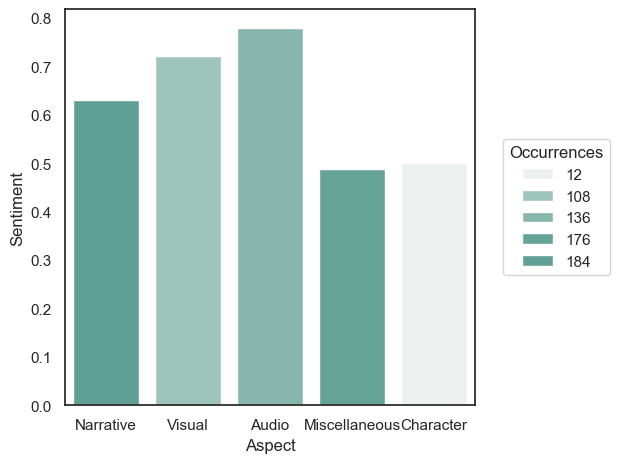

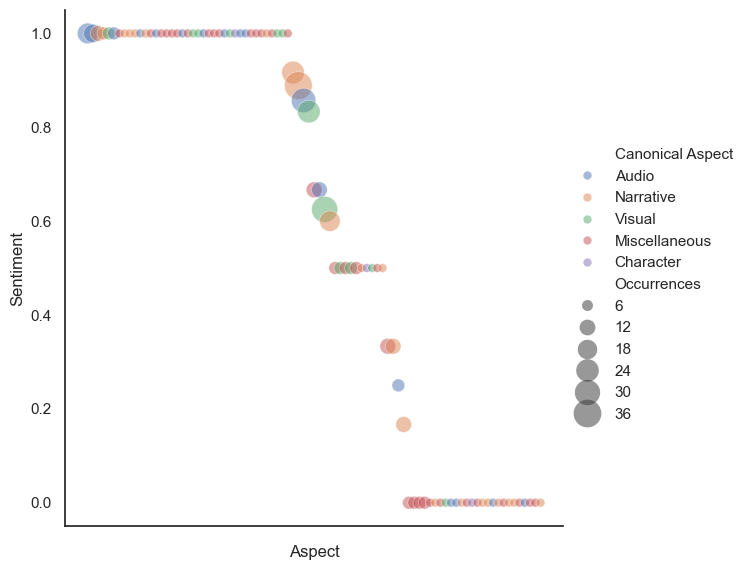

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

a = sns.barplot(x="Aspect", y="Sentiment", hue="Occurrences", palette="light:#5A9", data=aspect_df)
a.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Occurrences")
a.figure.savefig("seaborn_barplot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

b = sns.relplot(x="Aspect", y="Sentiment", hue="Canonical Aspect", size="Occurrences",
            sizes=(40, 400), alpha=.5,
            height=6, data=fine_grained_aspect_df).set(xticklabels=[])
b.figure.savefig("seaborn_relplot.png", dpi=300, bbox_inches="tight")

In [138]:
for aspect, aspect_data in canonical_aspect_scores.items():
    print(aspect, aspect_data["average_sentiment"], aspect_data["occurrences"])


Narrative 0.6304347826086957 184
Visual 0.7222222222222222 108
Audio 0.7794117647058824 136
Miscellaneous 0.48863636363636365 176
Character 0.5 12


# Coefficients for Overall Rating of Anime
Narrative = 25%
Visual =  25%
audio = 15%
Miscellaneous = 15%
Character = 20%


In [139]:
rating = 0
coefficients = {
    "Narrative": 0.25,
    "Visual": 0.25,
    "Audio": 0.15,
    "Miscellaneous": 0.15,
    "Character": 0.20
}

for aspect, aspect_data in canonical_aspect_scores.items():
    print(f"aspect {aspect} with cofficient {coefficients[aspect]} with average sentiment {aspect_data['average_sentiment']}")
    rating += coefficients[aspect] * aspect_data["average_sentiment"]

print(f"\nThe anime insert_name has an ABSA rating of {rating*100:.2f}% ")

aspect Narrative with cofficient 0.25 with average sentiment 0.6304347826086957
aspect Visual with cofficient 0.25 with average sentiment 0.7222222222222222
aspect Audio with cofficient 0.15 with average sentiment 0.7794117647058824
aspect Miscellaneous with cofficient 0.15 with average sentiment 0.48863636363636365
aspect Character with cofficient 0.2 with average sentiment 0.5

The anime insert_name has an ABSA rating of 62.84% 


# Animes aspect compared against each other

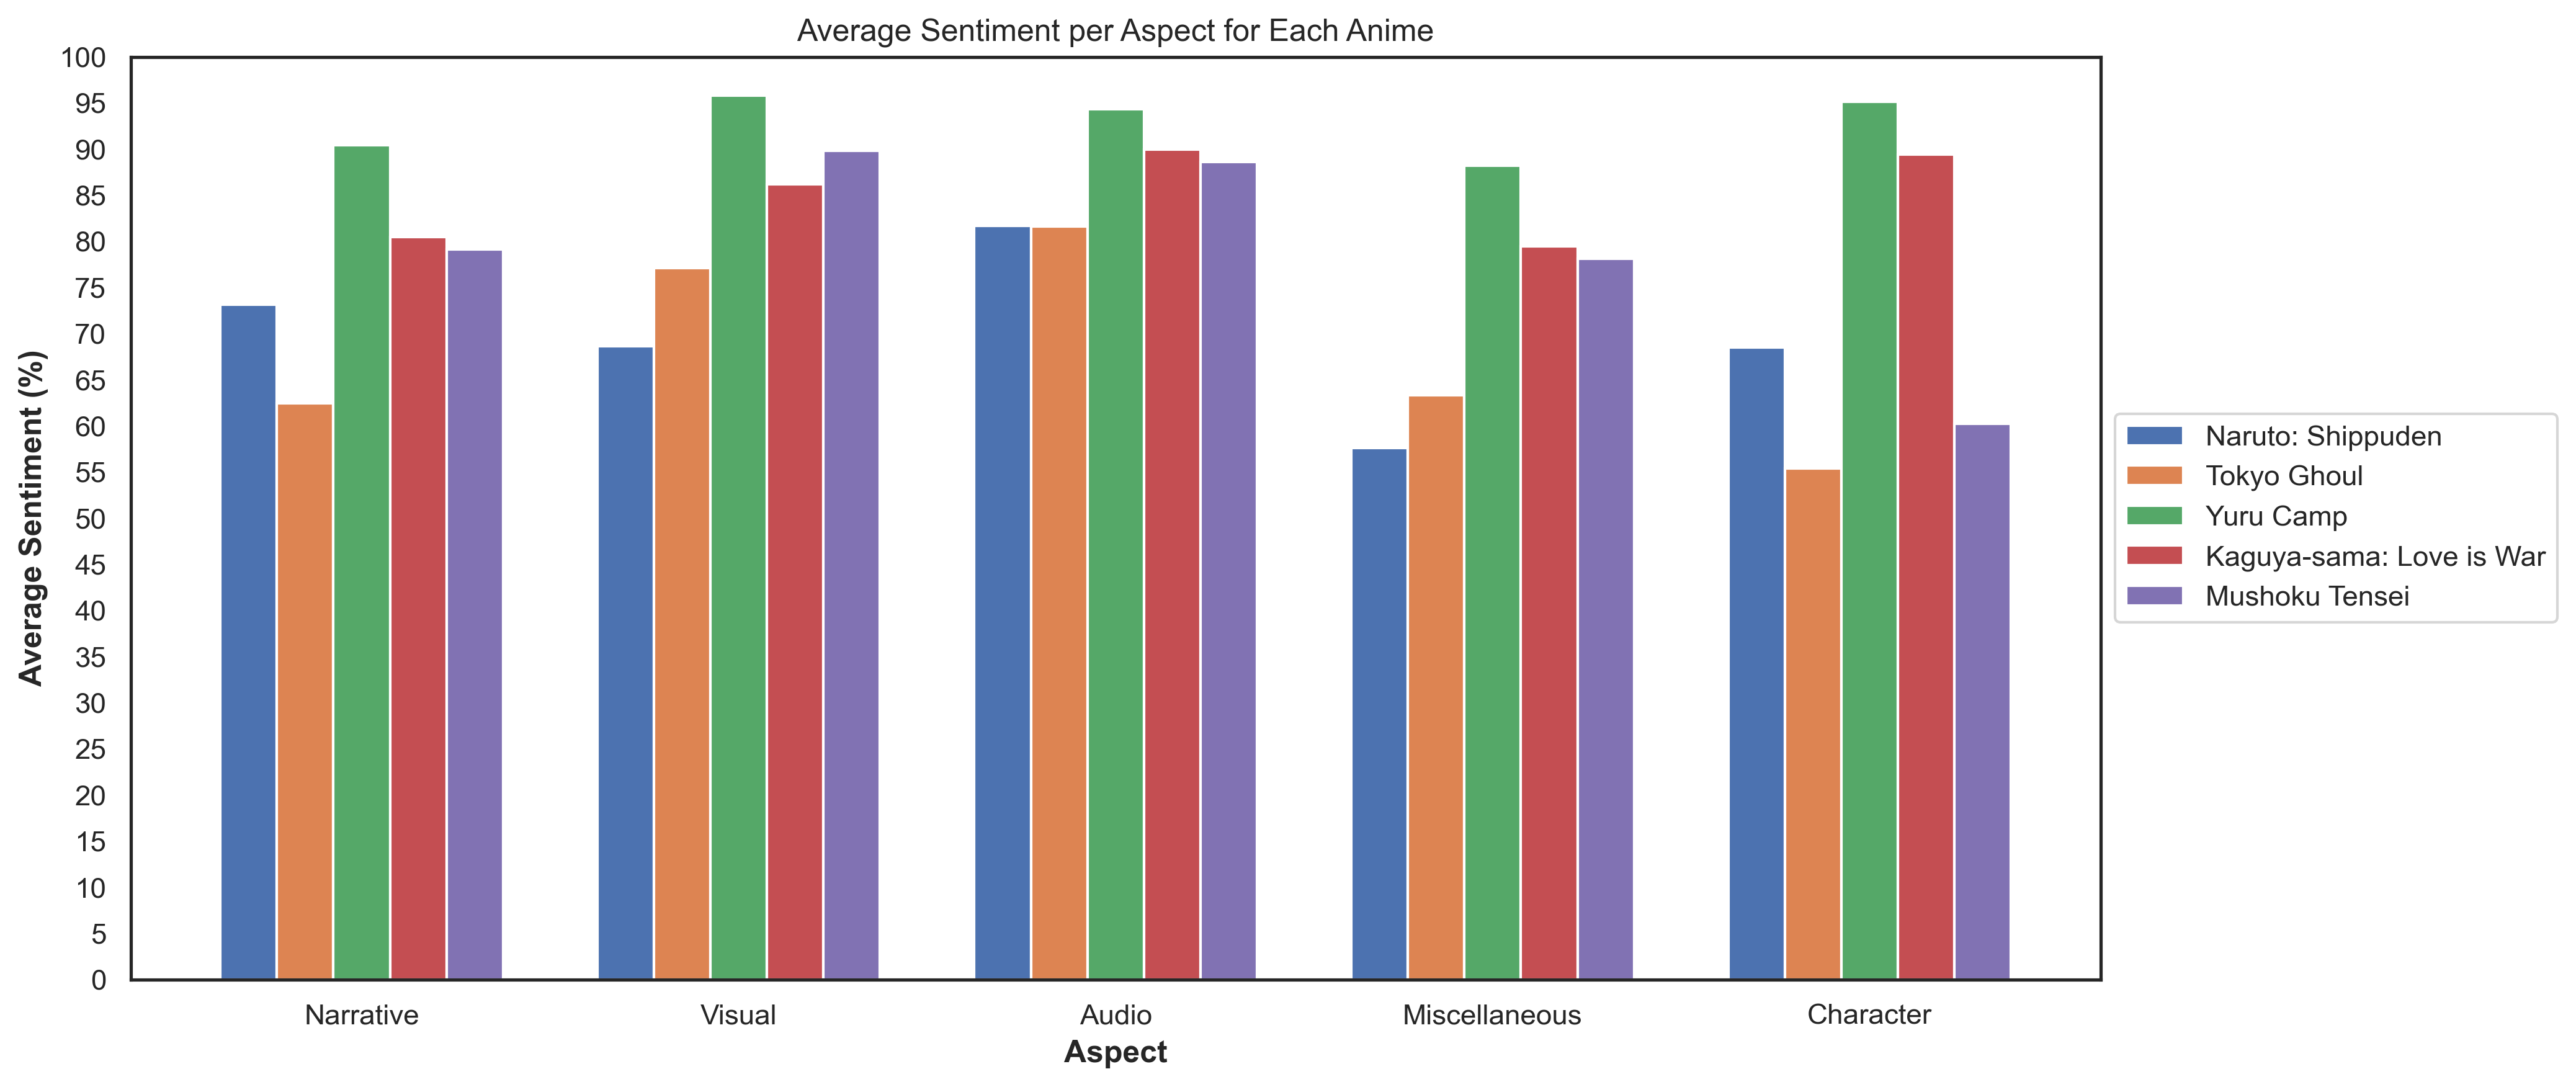

In [140]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("anime_coefficients.json", "r") as file:
    json_anime_coefficients = json.load(file)

anime_coefficients_aspect = ["Narrative", "Visual", "Audio", "Miscellaneous", "Character"]
anime_names = list(json_anime_coefficients.keys())

# Set bar width and initial x positions
barWidth = 0.15
positions = np.arange(len(anime_coefficients_aspect))

# Initialize plot
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

# Plot each anime's sentiment bars
for i, anime in enumerate(anime_names):
    values = [json_anime_coefficients[anime][aspect]["average_sentiment"] * 100 for aspect in anime_coefficients_aspect]
    bar_pos = positions + i * barWidth
    ax.bar(bar_pos, values, width=barWidth, label=anime)

# Set axis labels and ticks
ax.set_xlabel('Aspect', fontweight='bold')
ax.set_ylabel('Average Sentiment (%)', fontweight='bold')
ax.set_title('Average Sentiment per Aspect for Each Anime')
ax.set_xticks(positions + barWidth * (len(anime_names) - 1) / 2)
ax.set_xticklabels(anime_coefficients_aspect)
ax.set_ylim([0, 100])
ax.set_yticks(np.arange(0, 101, 5)) # Tick marks from 0 to 100 in steps of 5
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("anime_sentiment_barplot.png", bbox_inches='tight')
plt.show()

# ABSA Rankings vs. MyAnimeList Rankings

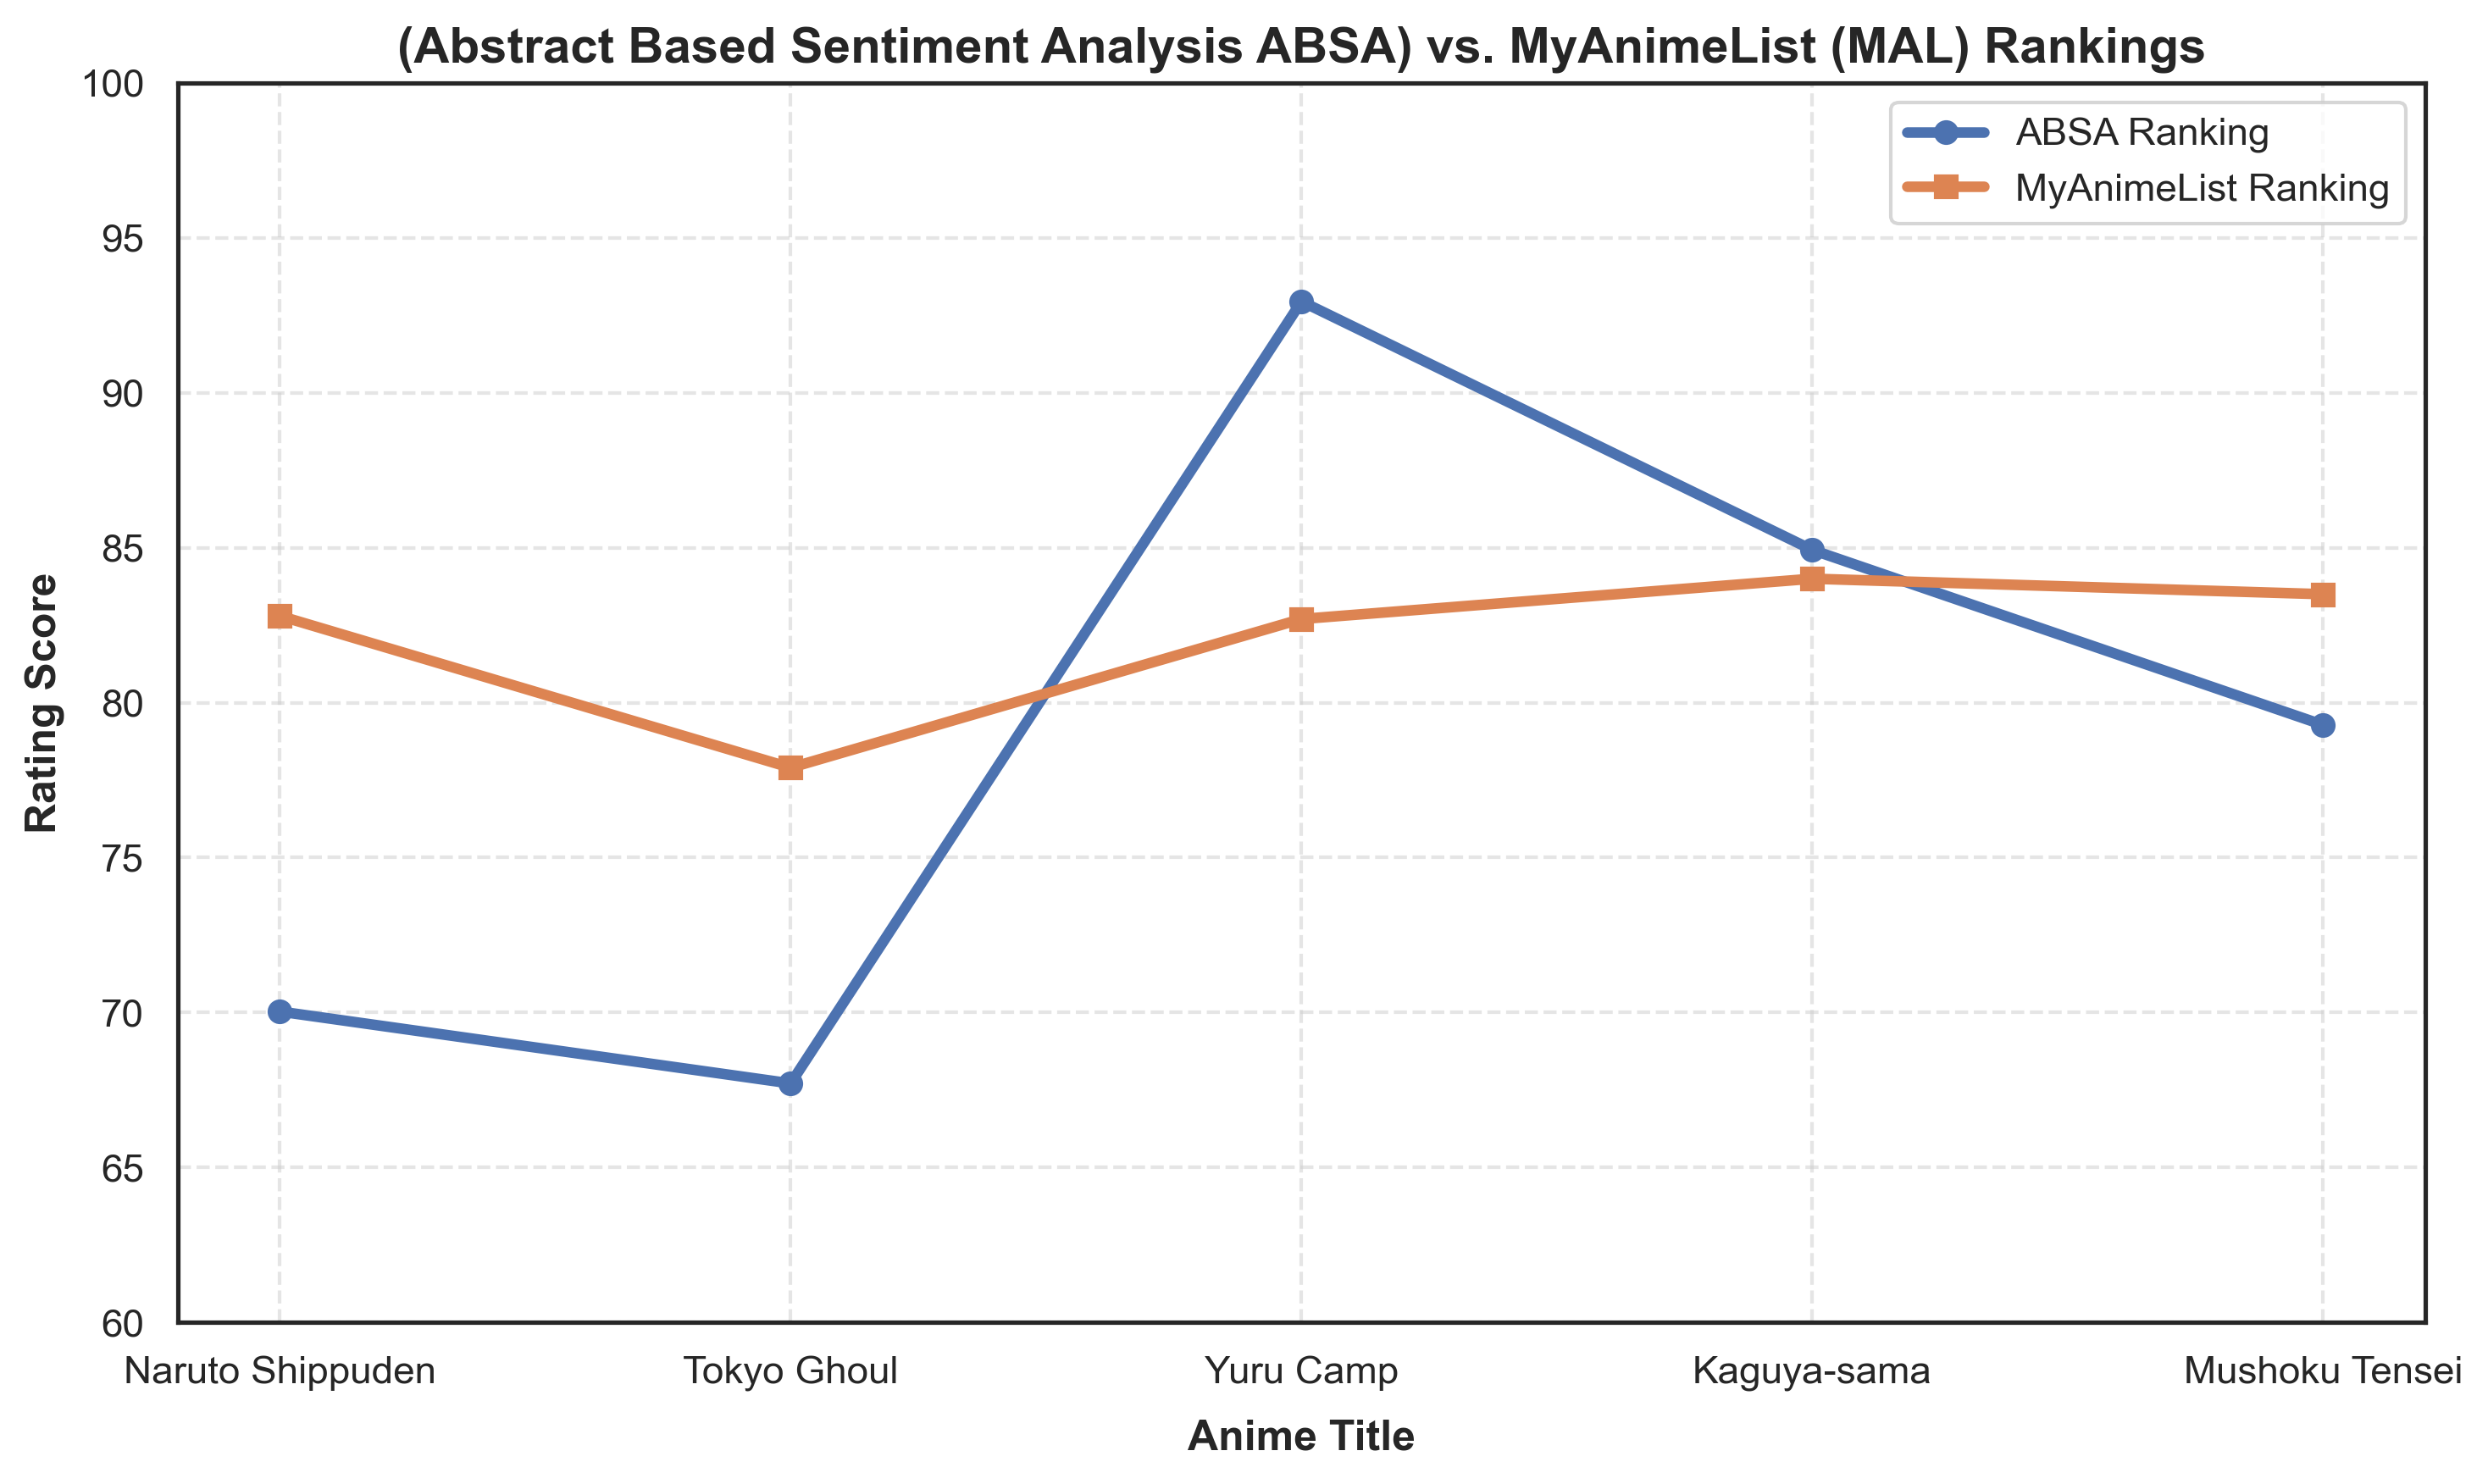

In [141]:
import matplotlib.pyplot as plt

# Data
anime_titles = ["Naruto Shippuden", "Tokyo Ghoul", "Yuru Camp", "Kaguya-sama", "Mushoku Tensei"]
absa_scores = [70.03, 67.71, 92.95, 84.93, 79.28]
mal_scores = [82.8, 77.9, 82.7, 84.0, 83.5]

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(anime_titles, absa_scores, marker='o', label='ABSA Ranking', linewidth=3)
plt.plot(anime_titles, mal_scores, marker='s', label='MyAnimeList Ranking', linewidth=3)

# Labels and aesthetics
plt.title("(Abstract Based Sentiment Analysis ABSA) vs. MyAnimeList (MAL) Rankings", fontsize=14, fontweight='bold')
plt.xlabel("Anime Title", fontweight='bold', labelpad=8)
plt.ylabel("Rating Score", fontweight='bold')
plt.ylim(60, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("absa_vs_mal.png", dpi=300, bbox_inches='tight')
plt.show()
